In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import MeCab
import ipadic
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


### Class

In [2]:
def hinshi_dist(text):
    word_type = ["その他","動詞","副詞","名詞","助動詞","記号","フィラー","接続詞","助詞","形容詞","連体詞","感動詞","接頭詞"]
    type_dic = {i:0for i in word_type}
    length = 0
    CHASEN_ARGS = r' -F "%m\t%f[7]\t%f[6]\t%F-[0,1,2,3]\t%f[4]\t%f[5]\n"'
    CHASEN_ARGS += r' -U "%m\t%m\t%m\t%F-[0,1,2,3]\t\t\n"'
    wakati = MeCab.Tagger(ipadic.MECAB_ARGS + CHASEN_ARGS)
    wakati_text = wakati.parse(text).split("\n")
    for line in wakati_text:
        tokens = line.split('\t')
        if tokens[0] != "" and tokens[0] != "EOS":
            if "-" in tokens[3]:
                result = tokens[3].split("-")[0]
            else:
                result = tokens[3]
            type_dic[result] += 1
            length += 1
    for key in type_dic.keys():
        type_dic[key] = type_dic[key]/length
    return type_dic






class Feature_extractor:


    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)

        self.save_folder = "features"
        self.features = {}

    def date_feature(self):
        dates = self.data["レビュー登録日時"].to_numpy()
        data_format = "%Y-%m-%d %H:%M"
        end_day = datetime.strptime("2019-12-31 23:59",data_format)
        self.features["df"] = [(end_day - datetime.strptime(date,data_format)).days for date in dates]

    def is_title(self):
        self.features["it"] = self.data["レビュータイトル"].isnull().to_numpy().astype(int)

    def is_mokuteki(self):
        self.features["im"] = self.data["目的"].isnull().to_numpy().astype(int)

    def is_ti(self):
        self.features["itsu"] = self.data["使い道"].isnull().to_numpy().astype(int)

    def is_hin(self):
        self.features["ih"] = self.data["頻度"].isnull().to_numpy().astype(int)

    def title_wc(self):
        self.tc = []
        wakati = MeCab.Tagger("-Owakati")
        file_name = "title_count.txt"
        if file_name not in os.listdir(self.save_folder):
            review = self.data["レビュータイトル"].to_numpy()
            for line in tqdm(review):
                if line is np.nan:
                    out = 0
                else:
                    out = len(wakati.parse(line).split())
                self.tc.append(out)
            with open(os.path.join(self.save_folder,file_name), "w") as file:
                for line in self.tc:
                    file.write(str(line))
                    file.write("\n")
        else:
            with open(os.path.join(self.save_folder,file_name), "r") as file:
                self.tc = [int(line.replace("\n", "")) for line in file.readlines()]

        self.features["tc"] = self.tc

    def word_count(self):
        self.wc = []
        wakati = MeCab.Tagger("-Owakati")
        file_name = "word_count.txt"
        if file_name not in os.listdir(self.save_folder):
            with open(os.path.join(self.save_folder,file_name), "w") as file:
                review = self.data["レビュー内容"].to_numpy()
                for line in tqdm(review):
                    out = len(wakati.parse(line).split())
                    file.write(str(out))
                    file.write("\n")
                    self.wc.append(out)
        else:
            with open(os.path.join(self.save_folder,file_name), "r") as file:
                self.wc = [int(line.replace("\n", "")) for line in file.readlines()]

        self.features["wc"] = self.wc

    def score(self):
        self.features['score'] = self.data["評価ポイント"].to_numpy()
        # self.features['score'] = s(self.data['評価ポイント'] == 1).astype(int).to_numpy()
    def encode_mokuteki(self):
        return pd.get_dummies(self.data["目的"]).astype(int)

    def encode_hindo(self):
        return pd.get_dummies(self.data["頻度"]).astype(int)

    def encode_tsu(self):
        return pd.get_dummies(self.data["使い道"]).astype(int)

    def encode_denpou(self):
        # cate = self.data["店舗名"].to_frame()
        # le = LabelEncoder()
        # a = le.fit_transform(cate).flatten()
        # return pd.DataFrame({"denpou":a})
        self.features['denpo'] = self.data['店舗名'].map(self.data['店舗名'].value_counts()).to_numpy()

    def encode_goods(self):
        self.features['goods'] = self.data['商品名'].map(self.data['商品名'].value_counts()).to_numpy()

    def encode_users(self):
        self.features['user'] = self.data['投稿者ID'].map(self.data['投稿者ID'].value_counts()).to_numpy()

    def encode_genre(self):
        self.features['商品ジャンルID'] = self.data['商品ジャンルID'].map(self.data['商品ジャンルID'].value_counts()).to_numpy()

    def encode_hinshi(self): #词性
        word_type = ["その他","動詞","副詞","名詞","助動詞","記号","フィラー","接続詞","助詞","形容詞","連体詞","感動詞","接頭詞"]
        feature_dict = {}
        for typ in word_type:
            feature_dict[typ] = []

        for line in tqdm(self.data['レビュー内容']):
            result = hinshi_dist(line)
            for key in result.keys():
                feature_dict[key].append(result[key])

        for key in feature_dict.keys():
            self.features[key] = feature_dict[key]


    def get_y(self,cut_off:int):
        out = self.data["参考になった数"].to_numpy()
        return np.where(out > cut_off, 1, 0)

    def to_frame(self, cut_off,include_y=False):
        # self.date_feature()
        self.word_count() #单词数
        self.title_wc() #标题单词数
        self.is_title() #是否有标题
        self.is_mokuteki() #目的
        self.is_ti() #使い道
        self.is_hin() #頻度
        self.score() #评论分数
        self.encode_goods() #商品名
        self.encode_users() #用户
        self.encode_genre() #类别
        self.encode_denpou() #店铺
        self.encode_hinshi()
        encoded_hindo = self.encode_hindo() #使用频度
        encoded_mokuteki = self.encode_mokuteki() #使用目的
        encoded_tsu = self.encode_tsu() #使用方法

        if include_y:
            self.features['y'] = self.get_y(cut_off)

        data = pd.DataFrame(self.features)
        data = pd.concat([data, encoded_mokuteki,encoded_hindo, encoded_tsu, encoded_tsu], axis = 1)
        return data



### Main

In [3]:
import oseti

In [4]:
path = "/home/hc/[NII-IDR] 楽天市場データ/review/sample/sample_from_raw_5.csv"
extractor = Feature_extractor(path)
X = extractor.to_frame(include_y=True,cut_off=5)

100%|██████████| 50000/50000 [00:36<00:00, 1357.55it/s]


In [9]:
X['y'].value_counts()

y
0    25000
1    25000
Name: count, dtype: int64

In [65]:
a = extractor.data[extractor.data['参考になった数']>5]['レビュー内容'].to_frame().reset_index()
a['レビュー内容'][66]

'１２本入りを見逃した まあ いろんな味が飲みたかったので大失敗 製品自体は特に問題なし 水でした 笑'

In [66]:
a = extractor.data[extractor.data['参考になった数']<=5]['レビュー内容'].to_frame().reset_index()
a['レビュー内容'][4]

'ホースとノズルの接続がすんなりと行かず苦労した。１０個ノズルがあるのだが６個でギブアップ、水道に接続するが水圧が強いのか接続部が抜け現在使用していない。'

<Axes: xlabel='count', ylabel='score'>

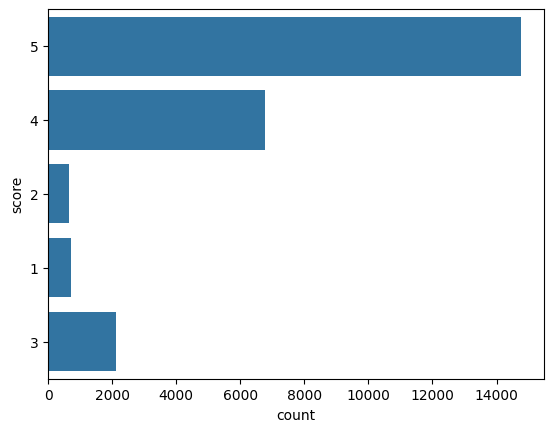

In [30]:
stat = X[X['y']==0]['score'].astype(str)
sns.countplot(stat)

<Axes: xlabel='count', ylabel='score'>

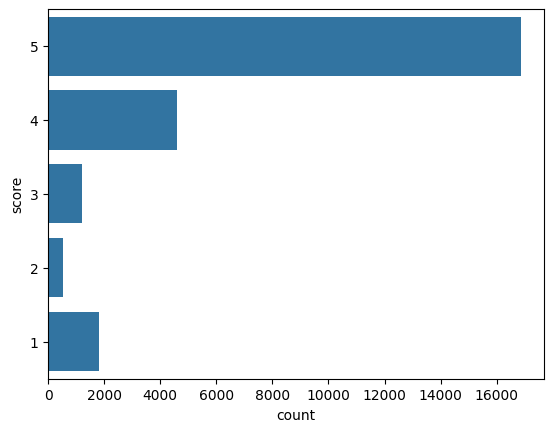

In [31]:
stat = X[X['y']==1]['score'].astype(str)
sns.countplot(stat)